In [20]:
import os
import math
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict

In [21]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
calibration_df = pd.read_csv("Outputs/trace_baseline.csv")
calibration_df.set_index('timestep', inplace=True)
calibration_df.drop('Unnamed: 0', axis = 1, inplace=True)

In [22]:
def clean_shortfalls(shortfall):
    if shortfall < 0:
        return 0
    else:
        return shortfall

In [23]:
calibration_df['kg_hydro_shortfall'] = calibration_df['kg_hydro_shortfall'].apply(lambda shortfall: clean_shortfalls(shortfall))
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,it_baseflow,...,it_outflow,kg_depth,kg_inflow,kg_hydro_demand,kg_gated_release,kg_hydro_release,kg_hydro_production,kg_hydro_shortfall,kg_spilled_release,kg_volume
timestep,,,,,,,,,,,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,1140.000000,...,2510.629085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,1716.087759,...,3704.130998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,2041.081042,...,2041.136670,394.957574,3566.361847,668.493613,669.273613,668.493613,792.924108,0.0,2647.088234,899.927778
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,1680.439559,...,1680.339560,398.000168,2217.262089,641.983719,642.763719,641.983719,792.962267,0.0,1574.426148,899.900008
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,1129.351359,...,1129.251361,397.999830,1689.559949,663.383740,664.163740,663.383740,792.931226,0.0,1025.296217,899.900011


In [24]:
hydro_target = 792 # mw per month
consumption = 300 # max kw per hour

In [25]:
def power_outage(hydro_shortfall, hydro_target, consumption):
    #returns assumed power outage in kilowatts per month, based on portion of hydropower target not met.
    #requires 'shortfall' in megawatts per month, 'hydro_target' in megawatts per month, 'consumption' in kilowatts per hour
    return hydro_shortfall / hydro_target * consumption

In [26]:
treatment_target = 90000 # m3 per day
treatment_capacity = 112500 # m3 per day

In [27]:
def treatment_shortfall(hydro_shortfall, hydro_target, treatment_target, month):
    #returns assumed water treatment shortfall in m3 per month, based on portion of hydropower target not met
    #requires 'shortfall' in megawatts per month, 'hydro_target' in megawatts per month, 'treatment_target' in m3 per day
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31 }
    return hydro_shortfall / hydro_target * treatment_target * days_in_month[month]

In [28]:
def treatment_shortfall_running_total(shortfall_previous, shortfall):
    if shortfall == 0:
        return 0
    else:
        return shortfall + shortfall_previous

In [29]:
def monthly_shortfalls(df, hydro_target, consumption, treatment_target, treatment_capacity):
    shortfall_previous = 0
    #df['kg_hydro_shortfall'].apply(lambda shortfall: clean_shortfalls(shortfall))
    for index, row in df.iterrows():         
        #compute values
        hydro_shortfall = clean_shortfalls(row['kg_hydro_shortfall'])
        outage = power_outage(hydro_shortfall, hydro_target, consumption)
        shortfall = treatment_shortfall(hydro_shortfall, hydro_target, treatment_target, row['month'])
        shortfall_running = treatment_shortfall_running_total(shortfall_previous, shortfall)
        #commit to data frame
        df.at[index,'hydro_shortfall'] = hydro_shortfall
        df.at[index,'power_outage'] = outage
        df.at[index,'treatment_shortfall'] = shortfall
        df.at[index,'treatment_shortfall_running'] = shortfall_running
        #update values
        shortfall_previous = shortfall_running
    return df

In [30]:
calibration_df = monthly_shortfalls(calibration_df, hydro_target, consumption, treatment_target, treatment_capacity)

In [31]:
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,it_baseflow,...,kg_gated_release,kg_hydro_release,kg_hydro_production,kg_hydro_shortfall,kg_spilled_release,kg_volume,hydro_shortfall,power_outage,treatment_shortfall,treatment_shortfall_running
timestep,,,,,,,,,,,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,1140.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,1716.087759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,2041.081042,...,669.273613,668.493613,792.924108,0.0,2647.088234,899.927778,0.0,0.0,0.0,0.0
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,1680.439559,...,642.763719,641.983719,792.962267,0.0,1574.426148,899.900008,0.0,0.0,0.0,0.0
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,1129.351359,...,664.163740,663.383740,792.931226,0.0,1025.296217,899.900011,0.0,0.0,0.0,0.0


In [32]:
annual_treatment_shortfall_df = pd.DataFrame(calibration_df.groupby(['year'])['treatment_shortfall_running'].max())
annual_power_shortfall_df = pd.DataFrame(calibration_df.groupby(['year'])['power_outage'].max())
annual_shortfall_df = annual_power_shortfall_df.merge(annual_treatment_shortfall_df, how='left', on='year')
print(annual_shortfall_df)

      power_outage  treatment_shortfall_running
year                                           
1         0.000000                 0.000000e+00
2         0.000000                 0.000000e+00
3         0.980654                 9.120082e+03
4       106.397037                 2.096096e+06
5        97.959694                 1.488034e+06
6        83.479559                 1.111318e+06


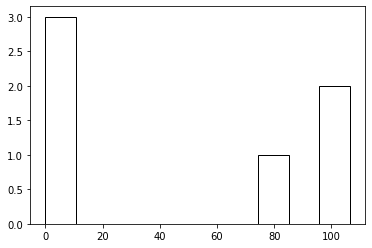

In [33]:
annual_power_shortfall_distribution_plot = plt.hist(annual_power_shortfall_df['power_outage'], color='grey', fill=False)

In [34]:
def process_trace_data_wtp(in_dir, out_dir, hydro_target, consumption, treatment_target, treatment_capacity):
    directory = os.listdir(in_dir)
    for file_name in directory:
        df = pd.read_csv(in_dir + '/' + file_name)
        df.set_index('timestep', inplace=True, drop=True, verify_integrity=True)        
        df = monthly_shortfalls(df, hydro_target, consumption, treatment_target, treatment_capacity)
        df.to_csv(out_dir + '/' + file_name)   
        
        power_df = pd.DataFrame(df.groupby(['year'])['power_outage'].max())
        power_df = power_df.rename(columns = {'power_outage': file_name + '_max_power_outage'})
        treatment_df = pd.DataFrame(df.groupby(['year'])['treatment_shortfall_running'].max())
        treatment_df = treatment_df.rename(columns = {'treatment_shortfall_running': file_name + '_max_treatment_shortfall'})
        if directory.index(file_name) == 0:
            shortfall_df = power_df.merge(treatment_df, how='left', on='year')
        else:
            shortfall_df = shortfall_df.merge(power_df, how='left', on='year')
            shortfall_df = shortfall_df.merge(treatment_df, how='left', on='year') 
    shortfall_df.to_csv(out_dir + '/trace_annual_shortfalls.csv')

In [36]:
in_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/reservoirs"
out_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/wtp"

hydro_target = hydro_target
consumption = consumption
treatment_target = treatment_target
treatment_capacity = treatment_capacity

process_trace_data_wtp(in_directory, out_directory, hydro_target, consumption, treatment_target, treatment_capacity)

In [19]:
shortfall_df.head()

NameError: name 'shortfall_df' is not defined